# Amsterdam Listing

Let's import useful packages:

In [1]:
import gzip
import json
import csv
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import numpy as np

Pandas is a powerful and flexible library. Specifying the compression type we are able to read gzip files, a compression for huge csv files. In this case, we have set low memory as False because some columns have mixed types. Another recommendation is to establish the data types, but in csv there is not a complement file or extra information to know that.

In [4]:
listing = pd.read_csv('../Data/raw/listings.csv.gz', 
                      compression='gzip',
                      error_bad_lines=False, 
                      low_memory=False)

`info()` and `head()` provide us the big picture of listing data

In [5]:
listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20025 entries, 0 to 20024
Columns: 106 entries, id to reviews_per_month
dtypes: float64(23), int64(21), object(62)
memory usage: 16.2+ MB


In [6]:
listing.drop_duplicates(inplace=True)

In [7]:
listing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20025 entries, 0 to 20024
Columns: 106 entries, id to reviews_per_month
dtypes: float64(23), int64(21), object(62)
memory usage: 16.3+ MB


In [8]:
listing.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2818,https://www.airbnb.com/rooms/2818,20191207212953,2019-12-08,Quiet Garden View Room & Super Fast WiFi,Quiet Garden View Room & Super Fast WiFi,I'm renting a bedroom (room overlooking the ga...,Quiet Garden View Room & Super Fast WiFi I'm r...,none,"Indische Buurt (""Indies Neighborhood"") is a ne...",...,t,f,strict_14_with_grace_period,f,f,1,0,1,0,2.13
1,20168,https://www.airbnb.com/rooms/20168,20191207212953,2019-12-08,Studio with private bathroom in the centre 1,17th century Dutch townhouse in the heart of t...,For those who like all facets of city life. In...,17th century Dutch townhouse in the heart of t...,none,Located just in between famous central canals....,...,f,f,strict_14_with_grace_period,f,f,2,0,2,0,2.57
2,25428,https://www.airbnb.com/rooms/25428,20191207212953,2019-12-08,Lovely apt in City Centre (w.lift) near Jordaan,NaN,"This nicely furnished, newly renovated apt is...","This nicely furnished, newly renovated apt is...",none,NaN,...,f,f,strict_14_with_grace_period,f,f,2,2,0,0,0.13
3,27886,https://www.airbnb.com/rooms/27886,20191207212953,2019-12-08,"Romantic, stylish B&B houseboat in canal district",Stylish and romantic houseboat on fantastic hi...,For a romantic couple: A beautifully restored ...,Stylish and romantic houseboat on fantastic hi...,none,"Central, quiet, safe, clean and beautiful.",...,t,f,strict_14_with_grace_period,f,f,1,0,1,0,2.14
4,28871,https://www.airbnb.com/rooms/28871,20191207212953,2019-12-08,Comfortable double room,NaN,In a monumental house right in the center of A...,In a monumental house right in the center of A...,none,NaN,...,f,f,moderate,f,f,3,0,3,0,2.81


A brief inspection of columns enable us to split them according to the following **different categories of information**:

1. **General information of booking**: id, name, summary, description, space, experiences_offered, neighborhood overview, notes, transit, access, interaction, house_rules. To access that, select columns from `id` to `house_rules`.

2. **Host information**: id, name, location, about, response time, response rate, acceptance rate, listings count, verifications. In this case, select columns from `host_id` to `host_identity_verified`.

3. All about the **neighborhood**: city, state, market, cleansed. Extract this information selecting columns from `street` to `is_location_exact`.

4. Details of **property and conditions** are between the columns `property_type` and `maximum_nights_avg_ntm`.

5. **Calendar updates and availability** the next 30, 60 and 90 days, for instances. You can find this information between the columns `calendar_updated` and `calendar_last_scraped`.

6. **Reviews**: first and last review, number of reviews, scores rating, scores per accuracy, cleanliness, checkin, communication, location and value. Columns from `number of reviews` to `review_scores_value`.

7. **Verifications and licenses**: require guest profile picture, phone verification, cancellation policy, instant bookeable. Columns from `requires_license` to `require_guest_phone_verification`.

8. **Host listings counts** and reviews per month. Select from `calculated_host_listings_count` to `reviews_per_month`.

## 1. General information of booking

This section will be develop in details in further notebooks to apply Natural Language Processing to resolve the following challenges:

1. Empty summaries: Can we use the rest columns to create a summary for litings without one?
2. Common elements in Transit 
3. Common elements in house rules

In [9]:
booking_records = listing.loc[:, 'id':'house_rules']

In [10]:
booking_records.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20025 entries, 0 to 20024
Data columns (total 15 columns):
id                       20025 non-null int64
listing_url              20025 non-null object
scrape_id                20025 non-null int64
last_scraped             20025 non-null object
name                     19991 non-null object
summary                  19390 non-null object
space                    14654 non-null object
description              19783 non-null object
experiences_offered      20025 non-null object
neighborhood_overview    13641 non-null object
notes                    8389 non-null object
transit                  13922 non-null object
access                   11334 non-null object
interaction              12094 non-null object
house_rules              12215 non-null object
dtypes: int64(2), object(13)
memory usage: 2.4+ MB


## 2. Host Information

In [11]:
host_information = listing.loc[:, 'host_id': 'host_identity_verified']

In [12]:
host_information.drop_duplicates(inplace=True)

In [13]:
host_information.to_csv('../Data/interim/hosts_information.csv', index=False)

In [14]:
host_information.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17502 entries, 0 to 20024
Data columns (total 18 columns):
host_id                      17502 non-null int64
host_url                     17502 non-null object
host_name                    17353 non-null object
host_since                   17353 non-null object
host_location                17321 non-null object
host_about                   9780 non-null object
host_response_time           8549 non-null object
host_response_rate           8549 non-null object
host_acceptance_rate         0 non-null float64
host_is_superhost            17353 non-null object
host_thumbnail_url           17353 non-null object
host_picture_url             17353 non-null object
host_neighbourhood           12048 non-null object
host_listings_count          17353 non-null float64
host_total_listings_count    17353 non-null float64
host_verifications           17502 non-null object
host_has_profile_pic         17353 non-null object
host_identity_verified       

### How many listings/host?

To avoid duplicates host_id, we select only host_id and total_listing_count, deleting the duplicates:

In [15]:
unique_host_listings = host_information.loc[:, ['host_id', 'host_total_listings_count']].reindex().drop_duplicates().dropna()

In [16]:
total_listings_count = unique_host_listings.groupby('host_total_listings_count').count()

Graphical identification of outliers:

/Users/daniela/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3099: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  self.set_xlim(upper, lower, auto=None)


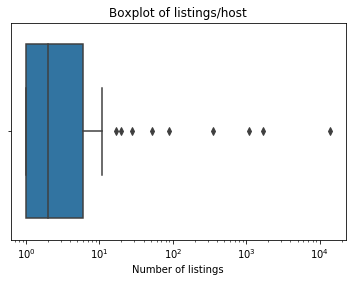

In [17]:
_ = plt.xscale('log')
_ = sns.boxplot(total_listings_count)
_ = plt.xlabel('Number of listings')
_ = plt.title('Boxplot of listings/host')

Almost all hosts have less than ten listings, but some results are a little unusual. The information is correct and it belongs to hotels chains, global marketplaces and home rental management companies. The most interesting aspect of that is their airbnb profiles look exactly the same of the rest of hosts. There is no extra information about the companies, avoiding the self promotion.

In [18]:
listing_counts = total_listings_count[(total_listings_count.index > 0) & (total_listings_count.index < 60)]

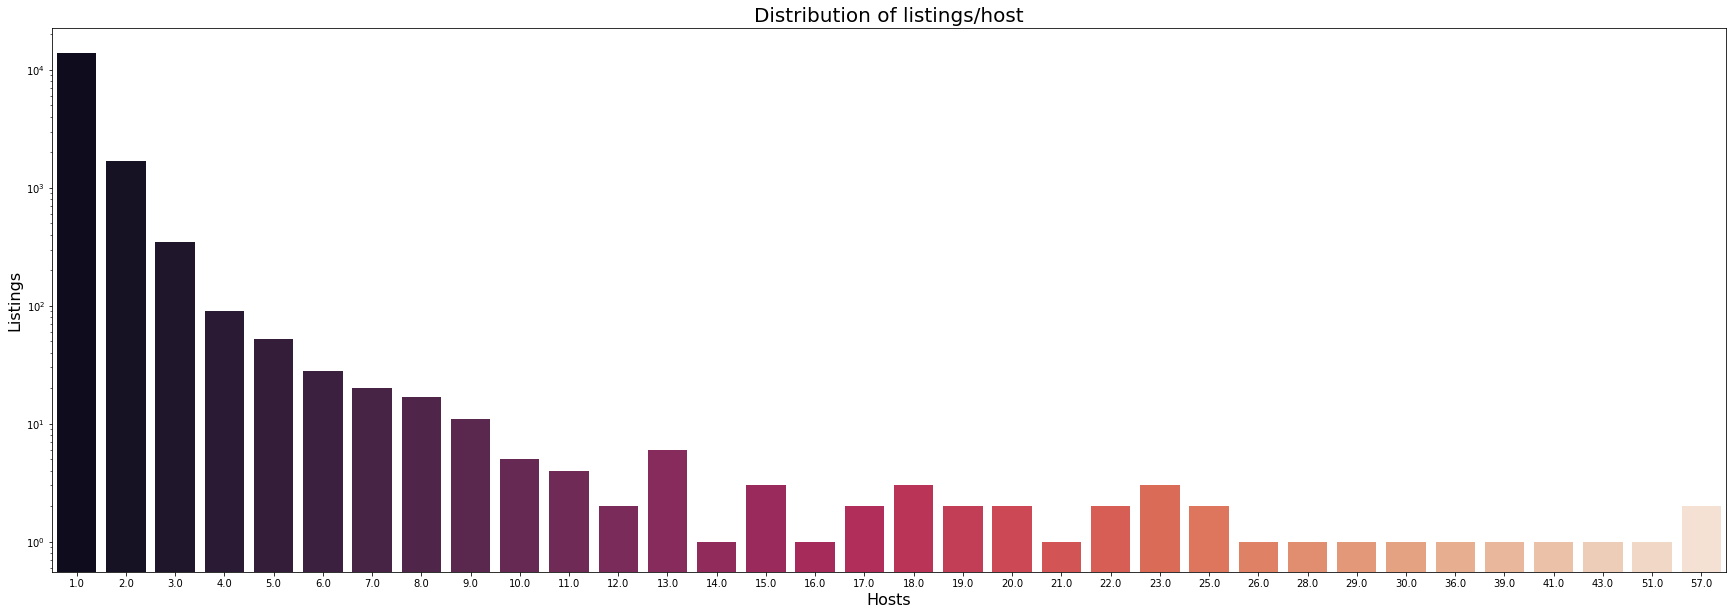

In [19]:
_ = plt.figure(figsize=(30,10))
_ = plt.yscale('log')
_ = sns.barplot(x=listing_counts.index, y=listing_counts.host_id, palette="rocket")
_ = plt.xlabel('Hosts', size=16)
_ = plt.ylabel('Listings', size=16)
_ = plt.title('Distribution of listings/host', size=20)

### Response Time of Hosts

There are 4 categories of response time:

In [20]:
response_time = host_information.groupby('host_response_time').count().host_id
response_time

host_response_time
a few days or more     327
within a day          2123
within a few hours    2170
within an hour        3929
Name: host_id, dtype: int64

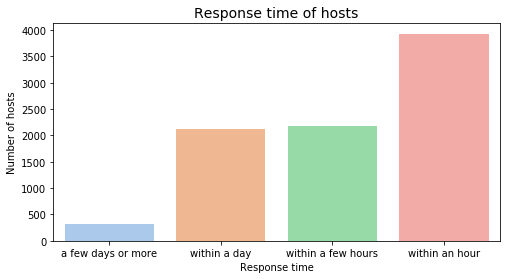

In [21]:
_ = plt.figure(figsize=(8, 4))
_ = sns.barplot(x=response_time.index, y=response_time, palette='pastel')
_ = plt.xlabel('Response time', size=10)
_ = plt.ylabel('Number of hosts', size=10)
_ = plt.title('Response time of hosts', size=14)

And in percentages:

In [22]:
100*response_time/response_time.sum()

host_response_time
a few days or more     3.825009
within a day          24.833314
within a few hours    25.383086
within an hour        45.958592
Name: host_id, dtype: float64

According to Airbnb, the response time is the average time that hosts take to respond to all messages in the last 30 days. This includes reservation requests, pre-approve and decline trip requests and reply new inquiries from guests and doesn't consider the follow-up messages between hosts and guests. 

From the Figure below it's possible conclude that hosts response quickly to their guests: about 46% of hosts reply their requests within an hour; approximately 50% of them take a few or more hours within the same day of the request and finally, almost 4% of hosts respond a few days later or more.

### Response Rate of Hosts

The response rate is the percentage of new requests (reservations and inquiries) that the hosts responded within 24 hours in the past 30 days. Neither response time or response rate consider the follow-up messages between hosts and guests.

In [23]:
def str_rate2int(rate):
    if type(rate) is str:
        return float(rate.replace("%", ""))
    else:
        return rate 

In [24]:
host_information['host_response_rate_float'] = host_information.host_response_rate.apply(str_rate2int).dropna()

In [25]:
response_rate = host_information.groupby('host_response_rate_float').count().host_id

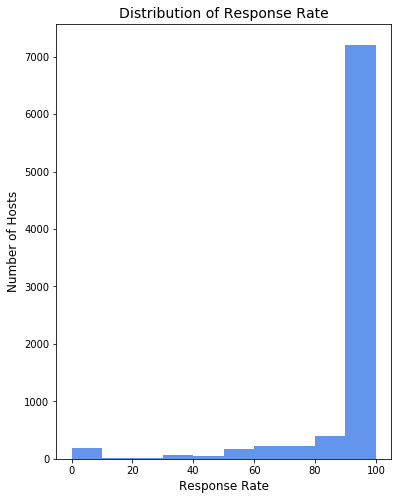

In [26]:
np.warnings.filterwarnings('ignore')

_ = plt.figure(figsize=(6,8))
_ = plt.hist(host_information['host_response_rate_float'], color='cornflowerblue')
_ = plt.xlabel('Response Rate', size=12)
_ = plt.ylabel('Number of Hosts', size=12)
_ = plt.title('Distribution of Response Rate', size=14)

In [27]:
response_rate_percent = response_rate/response_rate.sum()

In [28]:
print('Percentage of Hosts with a Response Rate of 100% the last 30 days: {}%'.format(response_rate_percent[100]))

Percentage of Hosts with a Response Rate of 100% the last 30 days: 0.79646742309042%


80% of hosts have respond all their messages within 24 hours the last month.

### What does "Superhost" mean?

Superhost is a status that hosts receive for good performance during the last 12 months. Some requirements include complete a specific number of trips, higher response rate, a minimum cancellation rate and an excelent overall rating. Let's see how difficult is to get this status.

In [29]:
def str2boolean(row):
    if row == 't':
        return True
    elif row == 'f':
        return False
    else:
        return np.nan

In [30]:
host_information['host_is_superhost_boolean'] = host_information.host_is_superhost.apply(str2boolean)

In [31]:
super_host = host_information.groupby('host_is_superhost_boolean').count().host_id

In [32]:
super_host/super_host.sum()

host_is_superhost_boolean
False    0.858872
True     0.141128
Name: host_id, dtype: float64

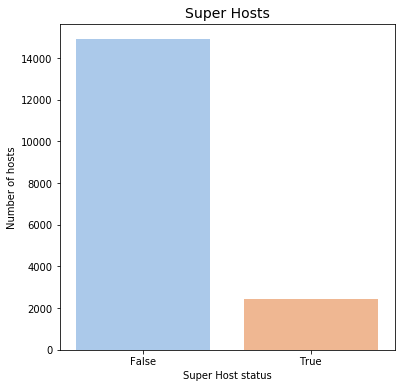

In [33]:
_ = plt.figure(figsize=(6, 6))
_ = sns.barplot(x =super_host.index, y =super_host, palette='pastel')
_ = plt.xlabel('Super Host status', size=10)
_ = plt.ylabel('Number of hosts', size=10)
_ = plt.title('Super Hosts', size=14)

Considering all the requirements to be a superhost is razonable that only 14% of them achieve this status. How higher the response rate is supposed to be to qualify as superhost?

In [34]:
sub_listings_50 = host_information[host_information.host_total_listings_count <= 50]

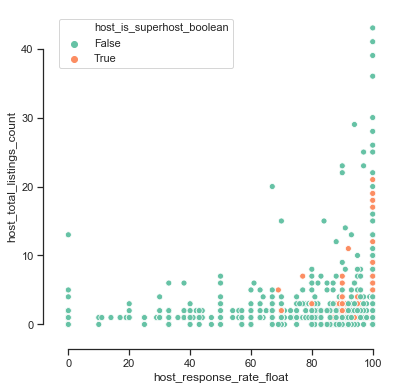

In [35]:
_ = sns.set(style="ticks", palette="Set2")

f, ax = plt.subplots(figsize=(6, 6))
_ = sns.despine(f, left=True, bottom=True)
_ = sns.scatterplot(x="host_response_rate_float",
                    y="host_total_listings_count", 
                    hue="host_is_superhost_boolean",
                    data=sub_listings_50, ax=ax)
_ = sns.despine(offset=10, trim=True)

### Neighborhoods in Amsterdam

Amsterdam, a cosmopolitan city with a population around 860 thousands of people, more than 2500 bridges, 165 canals and almost 8900 past centuries built heritage, is split into 8 districts which are further divided into unique neighbordhoods. What are the neighborhoods that concentrate more listings on Airbnb?


Ref: [ https://www.amsterdamsights.com/about/neighborhoods.html ] 

In [36]:
host_neighbourhood = host_information.groupby('host_neighbourhood').count()


In [37]:
host_neighbourhood.reset_index().to_csv('../Data/interim/neighbourhoods.csv', index=False)

In [38]:
host_neighbourhood_popular = host_neighbourhood[host_neighbourhood.host_id > 100]

In [39]:
list(host_neighbourhood_popular.index)

['Amsterdam Centrum',
 'Bos en Lommer',
 'De Pijp',
 'De Wallen',
 'Frederik Hendrikbuurt',
 'Grachtengordel',
 'Hoofddorppleinbuurt',
 'IJplein en Vogelbuurt',
 'Indische Buurt',
 'Jordaan',
 'Museumkwartier',
 'Nieuwmarkt en Lastage',
 'Oost',
 'Oostelijke Eilanden en Kadijken',
 'Oosterparkbuurt',
 'Osdorp',
 'Oud-West',
 'Oud-Zuid',
 'Overtoomse Veld',
 'Rivierenbuurt',
 'Slotervaart',
 'Spaarndammer en Zeeheldenbuurt',
 'Stadionbuurt',
 'Watergraafsmeer',
 'Weesperbuurt en Plantage',
 'Westelijke Eilanden',
 'Zeeburg']

The list below represents the neighborhoods with more than one hundred of listings. Using that list, we wonder which places have more superhosts:

In [40]:
sub_popular_neigh = host_information.loc[host_information['host_neighbourhood'].isin(list(host_neighbourhood_popular.index))]

In [41]:
sub_popular_neigh_superhost = sub_popular_neigh[sub_popular_neigh.host_is_superhost_boolean == True]

In [42]:
sub_popular_neigh_superhost.groupby('host_neighbourhood').count().sort_values('host_id', ascending=False).host_id

host_neighbourhood
Oud-West                           331
Grachtengordel                     150
De Pijp                            144
Jordaan                            112
Bos en Lommer                       81
Oosterparkbuurt                     78
Indische Buurt                      67
Rivierenbuurt                       51
Nieuwmarkt en Lastage               50
Amsterdam Centrum                   45
Oost                                42
Weesperbuurt en Plantage            41
De Wallen                           38
Zeeburg                             37
Westelijke Eilanden                 34
Oostelijke Eilanden en Kadijken     33
Slotervaart                         30
Watergraafsmeer                     30
Frederik Hendrikbuurt               30
Oud-Zuid                            28
Hoofddorppleinbuurt                 28
Stadionbuurt                        28
Museumkwartier                      27
Osdorp                              27
Spaarndammer en Zeeheldenbuurt      25
IJplei

Let's explore these results. **Oud-West** 

**Oud-West**
Vondelpark runs down the eastern limits of Oud-West and the neighbourhood is only a short distance away from Amsterdam’s city centre. Despite its centrality, Oud-West is relatively laid-back and features several exceptionally wide streets lined with dozens of trendy bars, restaurants and concert venues. Most of these establishments are spread over Oud-West’s main thoroughfares, namely Overtoom, Kinkerstraat and De Clercqstraat.

Each of these roads has its own distinct vibe and its fair share of excellent watering holes. Foodies and cinephiles should definitely stop by De Hallen on Kinkerstraat, which contains a massive indoor food hall where local culinary experts sell their wares, as well as an independent cinema decked out in Art Deco panelling.

For foodie couples, Oud-West is the ideal base from which to explore the city.





**De Pijp**
As with most of Central Amsterdam’s outlying neighbourhoods, for a long time De Pijp housed the city’s working class, and was mainly constructed in the 19th century to fulfil increased demand for housing. Vestiges of this fascinating urban history are still visible throughout De Pijp and the neighbourhood is known for its typical, narrow townhouses, which were originally built to accommodate low-income families.

The whole neighbourhood revolves around Amsterdam’s most famous market, Albert Cuyp Markt, which attracts hundreds of visitors every day. Besides these stalls and trestles, De Pijp is also home to many excellent cafés and restaurants, and is well known by locals for its amazing brunch restaurants such as Little Collins, Bakers & Roasters and the Scandinavian Embassy.

With its cool boutiques and brunch spots, this area is where trendy twentysomethings like to reside. It’s a little out of town and is the perfect neighbourhood if you want to live like a true Amsterdammer.

In [43]:
# f, ax = plt.subplots(figsize=(20, 8))
# sns.despine(f, left=True, bottom=True)
# sns.barplot(sub_popular_neigh_superhost.host_neighbourhood, ax=ax)

In [44]:
# cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)

# f, ax = plt.subplots(figsize=(20, 8))
# sns.despine(f, left=True, bottom=True)
# sns.scatterplot(y="host_total_listings_count", 
#                 x="host_response_rate_float",
#                 style="host_is_superhost_boolean",
#                 hue='host_neighbourhood',
#                 sizes=(150, 150),
#                 size="host_is_superhost_boolean",
#                 palette="Set2",
#                 data=sub_popular_neigh, ax=ax)

### Hosts Verification


Host and guest verification contribute to the security of the community against fraud. Airbnb ask for additional verification periodically to confirm the identity and the age of their users. This identification include update of profiles with recent photos and take a photo of a valid goverment ID, as a mean of establishing trust and to ensure that all payments made via the platform are valid transactions. Let's inspect some columns associated with the host verification.

In [45]:
host_verification = host_information.loc[:, ['host_id', 'host_verifications']].reset_index()
host_verification.drop(columns ='index', inplace=True)

In [46]:
host_verification.head(15)

,host_id,host_verifications
0,3159,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1,59484,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
2,56142,"['email', 'phone', 'reviews']"
3,97647,"['email', 'phone', 'reviews', 'jumio']"
4,124245,"['email', 'phone', 'reviews', 'jumio']"
5,133488,"['email', 'phone', 'facebook', 'reviews', 'jum..."
6,178515,"['email', 'phone', 'facebook', 'reviews', 'jum..."
7,187580,None
8,188098,"['email', 'phone', 'facebook', 'reviews', 'jum..."
9,65041,"['email', 'phone', 'reviews']"


Displaying the five first columns of the `host_verification` table allow us to know that for every host ID there are different identification resources or features as email, phone, reviews, facebook, jumio (a verified identification feature that allows people scan and verify their goverment-issued photo ID) and more. Next, verifications are group by feature to know which are mandatory requirements and how many people share extra information, as selfies or facebook profile

In [47]:
# print('Lenght of data before drop duplicates hosts ID: {}'.format(host_verification.shape[0]))
# host_verification.drop_duplicates()
# print('Lenght of data after drop duplicates hosts ID: {}'.format(host_verification.shape[0]))

In [48]:
n = host_verification.shape[0]
dict_verification = {}

for i in range(n):
    verification = host_verification.host_verifications[i]
    if verification != 'None':
        list_verification = verification.replace('[', '').replace(']', '').replace(" ", "").split(',')
        for j in list_verification:
            if len(j) > 1:
                j = j.replace("'", "")
                if j in dict_verification.keys():
                    dict_verification[j] += 1
                else:
                    dict_verification[j] = 1

In [49]:
for key, value in dict_verification.items():
    print(key, value)

email 16094
phone 16880
reviews 13556
jumio 10653
offline_government_id 4798
selfie 3552
government_id 5765
identity_manual 3392
facebook 4303
work_email 2172
google 649
manual_offline 338
manual_online 96
sent_id 13
kba 53
weibo 3
zhima_selfie 3
sesame 1
sesame_offline 1


In [50]:
new_dict_verification = {}

for key, value in dict_verification.items():
    if value > 100:
        new_dict_verification[key] = value

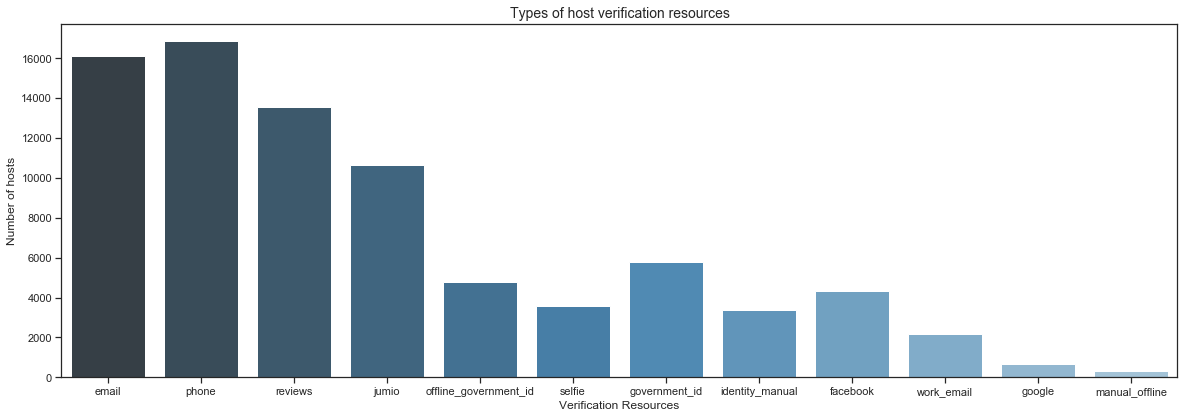

In [51]:
plt.figure(figsize=(20,6.5))
_ = sns.barplot(x=list(new_dict_verification.keys()), y=list(new_dict_verification.values()), palette='Blues_d')
_ = plt.xlabel('Verification Resources', size=12)
_ = plt.ylabel('Number of hosts', size=12)
_ = plt.title('Types of host verification resources', size=14)

Guests need a phone number to contact hosts, therefore it makes sense this feature is mandatory. Email is the most popular verification system in almost all the applications that require the creation of an account or profile. Reviews are essencial to confirm identification during the time to be sure that the original host is still there replying reviews and jumio, as we described before, allow people to scan their goverment ID for online verification. More hosts use more online goverment verification than of offline and selfies, facebook, google and manual identification are less completed.

In [52]:
host_information.shape[0]

17502

1. General information. Create a summary in empty listings using the information in the rest of columns (description, space, experiences_offered, neighborhood overview, notes, transit, access, interaction, house_rules)
2. Analisis of host: from 'host_id' to 'host_identity_verified'
3. Analisis of neighborhood: from 'street' to 'is_location_exact'
4. Details of property and conditions: from 'property_type' to ;maximum_nights_avg_ntm'

2. Analisis of security checks: require guest profile picture, phone verification, cancellation policy, instant bookeable
3. Neighborhood overview with respect to the demand (reviews, rating)
4. Type of host: entire home, private rooms, shared rooms and guest perception of them (People prefer any of them in determine seasons, neighborhood, etc)

In [53]:
#sns.distplot(listing_counts.index, kde=False)
# _ = plt.hist(listing_counts.index, bins=30, facecolor='g', alpha=0.75)

In [54]:
#host_information.loc[host_information['host_total_listings_count'] == 751]